Import All Packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Prepare Data from CSV

In [2]:
data = pd.read_csv("merged_datasets.csv",header="infer")
data = data.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
data = data.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

Split Dataset

In [3]:
numShots = data["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = data.loc[data["SHOT_ID"]<= trainsetSize]
testdata = data.loc[data["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())



408
285
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
72671      286  4.049164  2.028385  2.685728
72672      286  4.100109  2.057798  2.770602
72673      286  4.148583  2.085784  2.852373
72674      286  4.196989  2.113732  2.933079
72675      286  4.246961  2.142583  3.012744


Normalize Data

In [77]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

   SHOT_ID         X    Y         Z
0        1  0.005270  0.0  0.247600
1        1  0.019367  0.0  0.257379
2        1  0.033543  0.0  0.267367
3        1  0.047036  0.0  0.276382
4        1  0.060821  0.0  0.285676
       SHOT_ID         X         Y         Z
72671      286  0.000413  0.000000  0.403754
72672      286  0.010658  0.004228  0.417271
72673      286  0.020407  0.008252  0.430295
72674      286  0.030142  0.012269  0.443149
72675      286  0.040192  0.016417  0.455837


<ipython-input-77-72e12523539e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
<ipython-input-77-72e12523539e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])


Sequence Function

In [8]:
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique():
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data) - sequence_length):
            sequence = shot_data[i:i+sequence_length]
            X.append(sequence)
            Y.append(shot_data[i+sequence_length])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Create Sequence for test and train

In [14]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)
print(X_train.dtype,Y_train.dtype)



X_test, Y_test = prepare_data(testdata, sequence_length)
print(X_test)


float64 float64
[[[4.04916399 2.02838485 2.68572776]
  [4.10010879 2.05779784 2.77060166]
  [4.14858254 2.08578417 2.85237278]
  ...
  [4.63029668 2.36390196 3.60070794]
  [4.67756706 2.39119353 3.67051048]
  [4.72456158 2.41832583 3.7370839 ]]

 [[4.10010879 2.05779784 2.77060166]
  [4.14858254 2.08578417 2.85237278]
  [4.19698933 2.11373185 2.9330795 ]
  ...
  [4.67756706 2.39119353 3.67051048]
  [4.72456158 2.41832583 3.7370839 ]
  [4.77176373 2.44557799 3.80413655]]

 [[4.14858254 2.08578417 2.85237278]
  [4.19698933 2.11373185 2.9330795 ]
  [4.24696092 2.14258296 3.01274371]
  ...
  [4.72456158 2.41832583 3.7370839 ]
  [4.77176373 2.44557799 3.80413655]
  [4.81684712 2.47160691 3.86635511]]

 ...

 [[7.70534925 8.41586328 6.39974928]
  [7.73348406 8.44939304 6.38875932]
  [7.7654072  8.48743755 6.37390662]
  ...
  [8.03617452 8.81012549 6.1221145 ]
  [8.06174806 8.84060284 6.08417658]
  [8.08802193 8.87191482 6.04428855]]

 [[7.73348406 8.44939304 6.38875932]
  [7.7654072  8.48743

Load Model If Exist Else Skip

In [73]:
lstmModel = load_model('Run3.h5')

Configure LSTM Model

In [88]:
lstmModel = Sequential()
lstmModel.add(LSTM(32,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(192, activation='relu',return_sequences=True))
lstmModel.add(LSTM(64, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [24]:
lstmModel = Sequential()
lstmModel.add(LSTM(192,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

Train model with training dataset sequence

In [25]:
lstmModel.fit(X_train, Y_train, epochs=50, validation_data=(X_test,Y_test))

Epoch 1/50
2138/2138 [==============================] - 248s 114ms/step - loss: 0.6909 - val_loss: 0.1554
Epoch 2/50
2138/2138 [==============================] - 243s 113ms/step - loss: 0.0582 - val_loss: 0.0596
Epoch 3/50
2138/2138 [==============================] - 241s 113ms/step - loss: 0.0451 - val_loss: 0.0460
Epoch 4/50
2138/2138 [==============================] - 242s 113ms/step - loss: 0.0393 - val_loss: 0.0543
Epoch 5/50
2138/2138 [==============================] - 241s 113ms/step - loss: 0.0365 - val_loss: 0.0458
Epoch 6/50
2138/2138 [==============================] - 243s 114ms/step - loss: 0.0305 - val_loss: 0.0297
Epoch 7/50
2138/2138 [==============================] - 241s 113ms/step - loss: 0.0293 - val_loss: 0.0403
Epoch 8/50
2138/2138 [==============================] - 242s 113ms/step - loss: 0.0267 - val_loss: 0.0404
Epoch 9/50
2138/2138 [==============================] - 240s 112ms/step - loss: 0.0210 - val_loss: 0.0388
Epoch 10/50
2138/2138 [=======================

Test Model with test dataset sequence

In [10]:
Y_pred = lstmModel.predict(X_test)
#Y_pred = scale.inverse_transform(Y_pred)


526/526 [==============================] - 10s 17ms/step


Get Mean Squared Error

In [69]:
mse = lstmModel.evaluate(X_test, Y_test)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', np.sqrt(mse))

526/526 [==============================] - 15s 27ms/step - loss: 0.0070
Mean Squared Error: 0.007017109543085098
Root Mean Squared Error: 0.0837681893267671


Save Model

In [28]:
print("Saving Model")
lstmModel.save('Run5.h5')
print("Model Saved")

Saving Model
Model Saved


Plotting

In [45]:
Y_test = scale.inverse_transform(Y_test)

[[4.77176373 2.44557799 3.80413655]
 [4.81684712 2.47160691 3.86635511]
 [4.86256797 2.49800385 3.93199883]
 ...
 [8.1112429  8.8995885  6.0010449 ]
 [8.13834212 8.93188409 5.95202392]
 [8.16318423 8.96148976 5.90233837]]


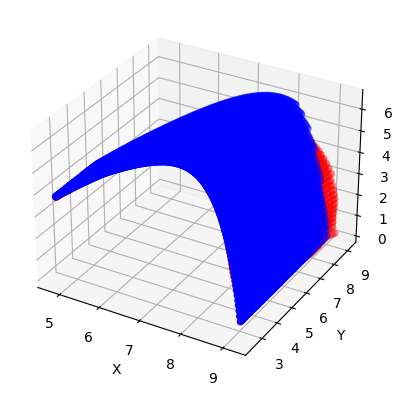

In [65]:
print(Y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test[:,0], Y_test[:,1], Y_test[:,2], color='b', label='Actual')
ax.scatter(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], color='r',label='Predicted')
plt.show()

Recursive Prediction

In [86]:
def recurcivePredict(dataArr,predictedTrajectory):
  predictedCord = lstmModel.predict(dataArr)
  print(predictedCord[0][2])
  if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][14][0]:
    dataArr = np.delete(dataArr,0,1)
    dataArr = np.append(dataArr,[predictedCord],axis=1)
    predictedTrajectory = np.append(predictedTrajectory,[predictedCord],axis=1)
    return recurcivePredict(dataArr,predictedTrajectory)
  else:
    return predictedTrajectory

initialInput = []
initialInput.append(testdata.iloc[40:55][['X', 'Y', 'Z']].values)
initialInput = np.array(initialInput)


trajectory = recurcivePredict(initialInput,initialInput)
print(trajectory)



1/1 [==============================] - 0s 23ms/step
5.7676177
1/1 [==============================] - 0s 25ms/step
5.8027697
1/1 [==============================] - 0s 25ms/step
5.8372154
1/1 [==============================] - 0s 22ms/step
5.8708234
1/1 [==============================] - 0s 25ms/step
5.9033246
1/1 [==============================] - 0s 22ms/step
5.9350605
1/1 [==============================] - 0s 24ms/step
5.966101
1/1 [==============================] - 0s 22ms/step
5.996431
1/1 [==============================] - 0s 25ms/step
6.0258145
1/1 [==============================] - 0s 23ms/step
6.0544815
1/1 [==============================] - 0s 22ms/step
6.0823035
1/1 [==============================] - 0s 22ms/step
6.1094747
1/1 [==============================] - 0s 22ms/step
6.1358438
1/1 [==============================] - 0s 21ms/step
6.1613016
1/1 [==============================] - 0s 27ms/step
6.185603
1/1 [==============================] - 0s 25ms/step
6.209058
1/1 [=======

Comparing Recursive prediction

In [66]:
testinput = []
testinput.append(data.loc[data['SHOT_ID'] == 286][['X', 'Y', 'Z']].values)
testinput = np.array(testinput)
print(testinput)

[[[4.04916399 2.02838485 2.68572776]
  [4.10010879 2.05779784 2.77060166]
  [4.14858254 2.08578417 2.85237278]
  [4.19698933 2.11373185 2.9330795 ]
  [4.24696092 2.14258296 3.01274371]
  [4.29709682 2.17152893 3.09136073]
  [4.34398141 2.19859776 3.16796786]
  [4.39473894 2.22790263 3.24431915]
  [4.44118126 2.25471612 3.31922627]
  [4.48796439 2.28172637 3.39176615]
  [4.53675439 2.30989529 3.46184784]
  [4.58351216 2.3368909  3.53183598]
  [4.63029668 2.36390196 3.60070794]
  [4.67756706 2.39119353 3.67051048]
  [4.72456158 2.41832583 3.7370839 ]
  [4.77176373 2.44557799 3.80413655]
  [4.81684712 2.47160691 3.86635511]
  [4.86256797 2.49800385 3.93199883]
  [4.91070805 2.52579754 3.99370622]
  [4.95454607 2.55110743 4.05716054]
  [5.00199909 2.57850445 4.11700577]
  [5.04604523 2.60393449 4.17571005]
  [5.0916131  2.63024312 4.23408918]
  [5.13450199 2.65500503 4.29435967]
  [5.18013125 2.6813491  4.35090269]
  [5.22496775 2.70723546 4.406717  ]
  [5.26738823 2.73172694 4.46179943]
 

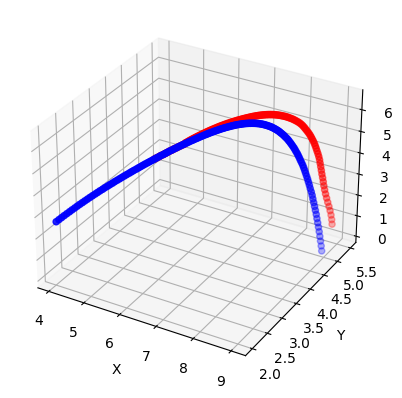

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
plt.show()